In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [2]:
!pip install torchvision

In [3]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
image_path = []
labels = []

for i in os.listdir("animal-faces/afhq"):
    for label in os.listdir(f"animal-faces/afhq/{i}"):
        for image in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)
        

data_df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
data_df

,image_path,labels
0,animal-faces/afhq/val/dog/pixabay_dog_002743.jpg,dog
1,animal-faces/afhq/val/dog/pixabay_dog_000917.jpg,dog
2,animal-faces/afhq/val/dog/pixabay_dog_000640.jpg,dog
3,animal-faces/afhq/val/dog/pixabay_dog_002792.jpg,dog
4,animal-faces/afhq/val/dog/pixabay_dog_003251.jpg,dog
...,...,...
16125,animal-faces/afhq/train/cat/flickr_cat_000313.jpg,cat
16126,animal-faces/afhq/train/cat/pixabay_cat_000497...,cat
16127,animal-faces/afhq/train/cat/pixabay_cat_000170...,cat
16128,animal-faces/afhq/train/cat/pixabay_cat_001966...,cat


In [5]:
train_image_path = []
labels = []

for label in os.listdir("animal-faces/afhq/train"):
    for image in os.listdir(f"animal-faces/afhq/train/{label}"):
        train_image_path.append(f"animal-faces/afhq/train/{label}/{image}")
        labels.append(label)

train_df = pd.DataFrame(zip(train_image_path, labels), columns = ["image_path", "labels"])

test_image_path = []
labels = []

for label in os.listdir("animal-faces/afhq/val"):
    for image in os.listdir(f"animal-faces/afhq/val/{label}"):
        test_image_path.append(f"animal-faces/afhq/val/{label}/{image}")
        labels.append(label)

test = pd.DataFrame(zip(test_image_path, labels), columns = ["image_path", "labels"])

train_df

,image_path,labels
0,animal-faces/afhq/train/dog/pixabay_dog_001917...,dog
1,animal-faces/afhq/train/dog/pixabay_dog_001641...,dog
2,animal-faces/afhq/train/dog/flickr_dog_001165.jpg,dog
3,animal-faces/afhq/train/dog/pixabay_dog_001058...,dog
4,animal-faces/afhq/train/dog/pixabay_dog_001452...,dog
...,...,...
14625,animal-faces/afhq/train/cat/flickr_cat_000313.jpg,cat
14626,animal-faces/afhq/train/cat/pixabay_cat_000497...,cat
14627,animal-faces/afhq/train/cat/pixabay_cat_000170...,cat
14628,animal-faces/afhq/train/cat/pixabay_cat_001966...,cat


In [6]:
train = train_df.sample(frac=0.75, random_state=7)
val = train_df.drop(train.index)

In [7]:
# PREPROCESSING OBJECTS
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [8]:
# CUSTOM DATA CLASS
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.fit_transform(self.dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, index):
        image_path = self.dataframe.iloc[index, 0]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [9]:
# CREATE DATASET OBJECTS
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)

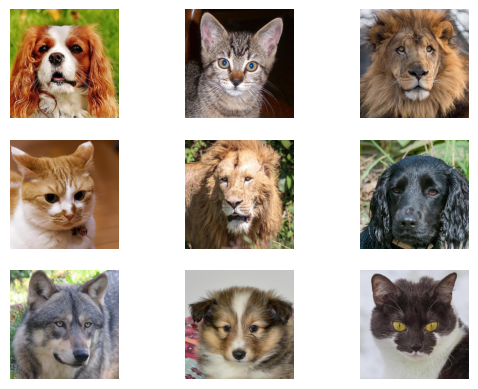

In [10]:
# VISUALIZE IMAGES

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

        # image, label = train_dataset.__getitem__(np.random.randint(0, train_dataset.__len__()))
        # axarr[row, col].imshow(image.permute(1, 2, 0))
        # axarr[row, col].set_title(label)
        # axarr[row, col].axis('off')

In [11]:
# HYPERPARAMETERS
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4

In [12]:
# DATALOADERS
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
# MODEL
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        # self.fc2 = nn.Linear(512, 128)
        # self.relu2 = nn.ReLU()

        self.output = nn.Linear(128, len(data_df['labels'].unique()))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu1(self.conv2(x)))
        x = self.pool(self.relu1(self.conv3(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        # x = self.relu2(self.fc1(x))
        # x = self.relu2(self.fc2(x))
        x = self.output(x)
        pred = self.softmax(x)
        return pred
    

model = Net().to(device)

In [19]:
# MODEL SUMMARY
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
          Softmax-13                    [-1, 3]               0
Total params: 4,288,067
Trainable param

In [20]:
# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [24]:
# TRAINING
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()

        train_acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
        
        total_acc_train += train_acc
        # print(f"Total train accuracy: {total_acc_train}")
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_acc_val += val_acc
            # print(f"Total val accuracy: {total_acc_val}")

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
                Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
    print("="*25)

Epoch 1/10, Train Loss: 4.3306 Train Accuracy 92.2712
                Validation Loss: 1.4445 Validation Accuracy: 92.3182
Epoch 2/10, Train Loss: 4.1947 Train Accuracy 94.1214
                Validation Loss: 1.3955 Validation Accuracy: 94.1225
Epoch 3/10, Train Loss: 4.0925 Train Accuracy 95.5888
                Validation Loss: 1.3703 Validation Accuracy: 95.3253
Epoch 4/10, Train Loss: 4.0437 Train Accuracy 96.4637
                Validation Loss: 1.3923 Validation Accuracy: 94.2865
Epoch 5/10, Train Loss: 3.9808 Train Accuracy 97.3205
                Validation Loss: 1.3579 Validation Accuracy: 95.708
Epoch 6/10, Train Loss: 3.9489 Train Accuracy 97.8126
                Validation Loss: 1.3351 Validation Accuracy: 96.9929
Epoch 7/10, Train Loss: 3.9319 Train Accuracy 98.0405
                Validation Loss: 1.3401 Validation Accuracy: 96.5828
Epoch 8/10, Train Loss: 3.9017 Train Accuracy 98.3959
                Validation Loss: 1.3572 Validation Accuracy: 95.8994
Epoch 9/10, Train

In [26]:
# SAVE THE MODEL PARAMETERS
PATH = 'image_classify_params.pth'
torch.save(model.state_dict(), PATH)

In [27]:
# TESTING
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, dim=1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f"Test accuracy is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Test accuracy is: 96.0667 and Loss is 0.0556


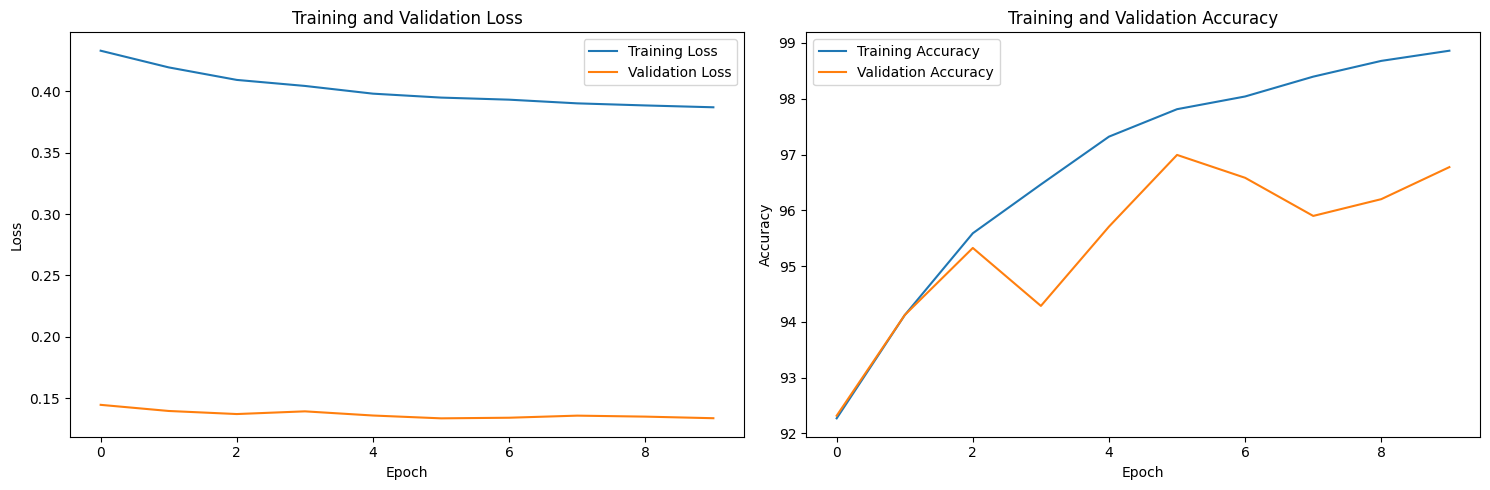

In [29]:
# Plotting Training Progress
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')   
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

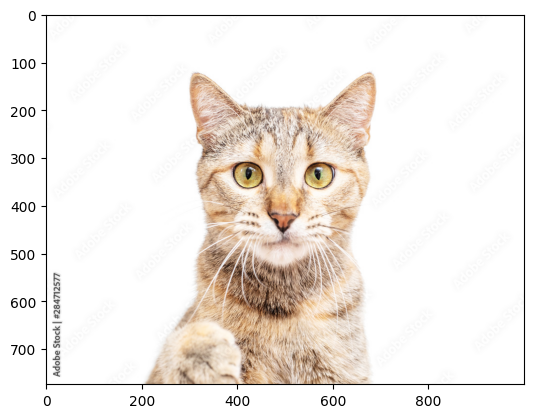


Prediction: 

Probabilities for each class:
  cat: 0.5757
  dog: 0.2120
  wild: 0.2123

Final Predicted Class: cat


'cat'

In [43]:
# INFERENCE
def predict_image(image_path):

    image = Image.open(image_path).convert("RGB")
    # Apply your transformations (e.g., resize, to_tensor, normalize)
    # Make sure 'transform' is defined globally or passed into the function
    image = transform(image).to(device)

    # Add a batch dimension (unsqueeze)
    image = image.unsqueeze(0)

    # Get the raw outputs (logits) from the model
    # It's good practice to wrap inference in torch.no_grad()
    # to disable gradient calculation, which saves memory and speeds up computation.
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(image)    

    # Apply Softmax to convert logits to probabilities
    # dim=1 because the classes are along the second dimension (batch_size, num_classes)
    probabilities = torch.softmax(output, dim=1)

    # Get the predicted class (the one with the highest probability)
    # This is useful if you still want a single label prediction
    _, predicted_class_idx = torch.max(probabilities, 1)
    predicted_label = label_encoder.inverse_transform(predicted_class_idx.cpu())[0]

    # Print probabilities for all classes
    print(f"Probabilities for each class:")
    for i, prob in enumerate(probabilities[0]): # probabilities[0] because it's a batch of 1
        class_name = label_encoder.inverse_transform([i])[0]
        print(f"  {class_name}: {prob.item():.4f}") # .item() to get scalar, .4f for 4 decimal places

    print(f"\nFinal Predicted Class: {predicted_label}")
    
    return predicted_label # Or return probabilities if you need them downstream


## Visualize the image
img_path_cat = 'cat looking at camera.jpg'
image = Image.open(img_path_cat)
plt.imshow(image)
plt.show()

## Predict
print()
print("Prediction: \n")
predict_image(img_path_cat)

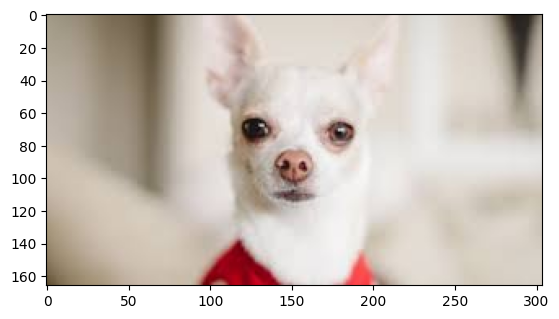


Prediction: 

Probabilities for each class:
  cat: 0.5746
  dog: 0.2132
  wild: 0.2123

Final Predicted Class: cat


'cat'

In [44]:
img_path_dog = 'dog.jpg'
image = Image.open(img_path_dog)
plt.imshow(image)
plt.show()

## Predict
print()
print("Prediction: \n")
predict_image(img_path_dog)

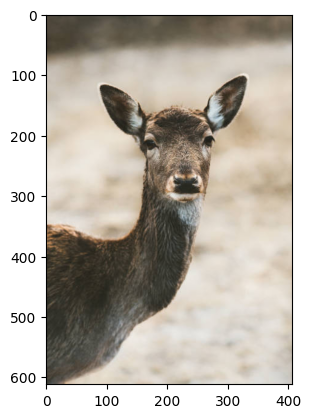


Prediction: 

Probabilities for each class:
  cat: 0.3247
  dog: 0.2305
  wild: 0.4447

Final Predicted Class: wild


'wild'

In [45]:
img_path_wild = 'wild_animal.jpg'
image = Image.open(img_path_wild)
plt.imshow(image)
plt.show()

## Predict
print()
print("Prediction: \n")
predict_image(img_path_wild)

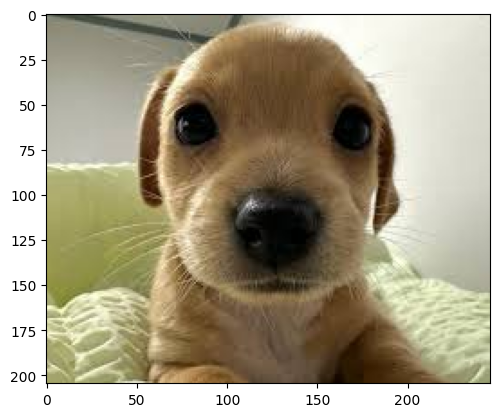


Prediction: 

Probabilities for each class:
  cat: 0.2119
  dog: 0.5761
  wild: 0.2119

Final Predicted Class: dog


'dog'

In [46]:
img_path_pup = 'puppy.jpg'
image = Image.open(img_path_pup)
plt.imshow(image)
plt.show()

## Predict
print()
print("Prediction: \n")
predict_image(img_path_pup)